In [1]:
tnt = require 'torchnet'
image = require 'image'

In [2]:
train = torch.load('../data/train.t7')
test = torch.load('../data/test.t7')
DATA_PATH = "../data"
WIDTH, HEIGHT = 32, 32

In [96]:
local function blend(img1, img2, alpha)
   return img1:mul(alpha):add(1 - alpha, img2)
end

local function grayscale(dst, img)
   dst:resizeAs(img)
   dst[1]:zero()
   dst[1]:add(0.299, img[1]):add(0.587, img[2]):add(0.114, img[3])
   dst[2]:copy(dst[1])
   dst[3]:copy(dst[1])
   return dst
end

function Saturation(var)
   local gs

   return function(input)
      gs = gs or input.new()
      grayscale(gs, input)

      local alpha = 1.0 + torch.uniform(-var, var)
      blend(input, gs, alpha)
      return input
   end
end

function Brightness(var)
   local gs

   return function(input)
      gs = gs or input.new()
      gs:resizeAs(input):zero()

      local alpha = 1.0 + torch.uniform(-var, var)
      blend(input, gs, alpha)
      return input
   end
end

function Contrast(var)
   local gs

   return function(input)
      gs = gs or input.new()
      grayscale(gs, input)
      gs:fill(gs[1]:mean())

      local alpha = 1.0 + torch.uniform(-var, var)
      blend(input, gs, alpha)
      return input
   end
end

In [141]:
function transformInputA(inp, theta_max, width, height, crop_1, crop_2, crop_3, crop_4)
  f = tnt.transform.compose{
      [1] = function(img) return image.crop(inp, crop_1, crop_2, crop_3, crop_4) end,
      [1] = function(img) return Saturation(0.8)(inp) end,
      [2] = function(img) return image.rotate(img, torch.uniform(- theta_max, theta_max), 'bilinear') end,
      [3] = function(img) return image.translate(img, torch.random(0, 5), torch.random(0, 5)) end,
      [4] = function(img) return image.scale(img, width + torch.random(-10, 10), height + torch.random(-10, 10), 'bicubic') end,
      [5] = function(img) return image.scale(img, width, height, 'bicubic') end
  }
    
  return f(inp)
end

In [94]:
function getTrainSample(dataset, idx)
    r = dataset[idx]
    print(r)
    classId, track, file = r[9], r[1], r[2]
    file = string.format("%05d/%05d_%05d.ppm", classId, track, file)
    -- Add transformInput here
    img = image.load(DATA_PATH .. '/train_images/'..file)
    itorch.image(image.crop(img, r[3], r[4], r[7], r[8]))
    return img, transformInput(img:clone(), 10 / 360 * math.pi, 52, 52, r[3], r[4], r[7], r[8])
end

function getTrainLabel(dataset, idx)
    return torch.LongTensor{dataset[idx][9]}
end

In [165]:
function getTestSample(dataset, idx)
    r = dataset[idx]
    file = DATA_PATH .. "/test_images/" .. string.format("%05d.ppm", r[1])
    print(r)
    img = image.load(file)
    itorch.image(img)
    print(r[7])
    return image.crop(img, r[4], r[5], r[6], r[7])
end

In [15]:
trainDataset = tnt.SplitDataset{
    partitions = {train=0.9, val=0.1},
    dataset = tnt.ShuffleDataset{
        dataset = tnt.ListDataset{
            list = torch.range(1, train:size(1)):long(),
            load = function(idx)
                return {
                    input =  getTrainSample(train, idx),
                    target = getTrainLabel(train, idx)
                }
            end
        }
    }
}

In [7]:
function getIterator(dataset)
    return tnt.DatasetIterator{
        dataset = tnt.BatchDataset{
            batchsize = 128,
            dataset = dataset
        }
    }
end

In [36]:
trainDataset:select('val')

In [37]:
iter = getIterator(trainDataset)

In [38]:
trainDataset:select('train')

In [39]:
trainDataset:size()

35288	


In [40]:
(35288+3920)/128

306.3125	


In [41]:
3920/128

30.625	


In [42]:
35288/128

275.6875	


In [43]:
iter.dataset

tnt.BatchDataset
{
  perm : function: 0x02daac78
  makebatch : function: 0x03d73500
  filter : function: 0x02daae48
  policy : include-last
  dataset : 
    tnt.SplitDataset
    {
      __partition : LongTensor - size: 1
      __names : 
        {
          train : 1
          val : 2
        }
      __partitionsizes : LongTensor - size: 2
      __dataset : 
        tnt.ShuffleDataset
        {
          __replacement : false
          __dataset : 
            tnt.ListDataset
            {
              load : function: 0x03d6a958
              list : LongTensor - size: 39209
            }
          __perm : LongTensor - size: 39209
          __sampler : function: 0x03d6b0c8
        }
    }
  batchsize : 128
}


In [44]:
Plot = require 'itorch.Plot'

In [66]:
training_images_width = torch.Tensor(trainDataset:size())
training_images_height = torch.Tensor(trainDataset:size())

iter = getIterator(trainDataset)

idx = 1

for d in iter() do
    for i, img in pairs(d.input) do
        training_images_width[idx] = img:size()[2]
        training_images_height[idx] = img:size()[3]
        idx = idx + 1
    end
end


In [67]:
plot = Plot():histogram(training_images_width):draw()
plot:title('Image Width histogram'):redraw()
plot:xaxis('Number'):yaxis('width'):redraw()

In [68]:
plot = Plot():histogram(training_images_height):draw()
plot:title('Image height histogram'):redraw()
plot:xaxis('Number'):yaxis('height'):redraw()

In [104]:
local function blend(img1, img2, alpha)
   return img1:mul(alpha):add(1 - alpha, img2)
end

local function grayscale(dst, img)
   dst:resizeAs(img)
   dst[1]:zero()
   dst[1]:add(0.299, img[1]):add(0.587, img[2]):add(0.114, img[3])
   dst[2]:copy(dst[1])
   dst[3]:copy(dst[1])
   return dst
end

function Saturation(var)
   local gs

   return function(input)
      gs = gs or input.new()
      grayscale(gs, input)

      local alpha = 1.0 + torch.uniform(-var, var)
      blend(input, gs, alpha)
      return input
   end
end

function Brightness(var)
   local gs

   return function(input)
      gs = gs or input.new()
      gs:resizeAs(input):zero()

      local alpha = 1.0 + torch.uniform(-var, var)
      blend(input, gs, alpha)
      return input
   end
end

function Contrast(var)
   local gs

   return function(input)
      gs = gs or input.new()
      grayscale(gs, input)
      gs:fill(gs[1]:mean())

      local alpha = 1.0 + torch.uniform(-var, var)
      blend(input, gs, alpha)
      return input
   end
end

In [152]:
function transformInputNew(inp, theta_max, width, height)
  f = tnt.transform.compose{
      [1] = function(img) return Saturation(0.8)(inp) end,
      [2] = function(img) return image.rotate(img, torch.uniform(- theta_max, theta_max), 'bilinear') end,
      [3] = function(img) return image.translate(img, torch.random(0, 5), torch.random(0, 5)) end,
      [4] = function(img) return image.scale(img, width + torch.random(-10, 10), height + torch.random(-10, 10), 'bicubic') end,
      [5] = function(img) return image.scale(img, width, height, 'bicubic') end
  }
    
  return f(inp)
end

In [155]:
function getTrainSample(dataset, idx)
    r = dataset[idx]
    classId, track, file = r[9], r[1], r[2]
    file = string.format("%05d/%05d_%05d.ppm", classId, track, file)
    -- Add transformInput here
    img = image.load(DATA_PATH .. '/train_images/'..file)
    
    return img, transformInputNew(image.crop(img, r[5], r[6], r[7], r[8]), 10 / 360 * math.pi, 52, 52)
end

function getTrainLabel(dataset, idx)
    return torch.LongTensor{dataset[idx][9]}
end

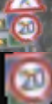

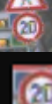

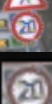

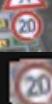

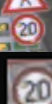

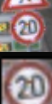

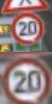

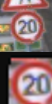

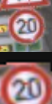

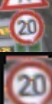

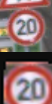

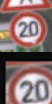

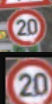

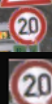

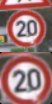

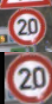

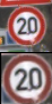

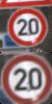

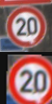

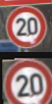

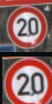

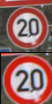

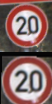

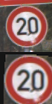

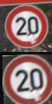

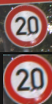

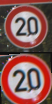

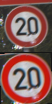

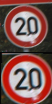

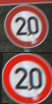

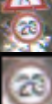

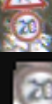

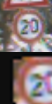

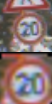

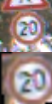

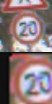

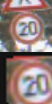

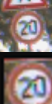

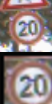

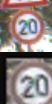

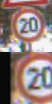

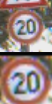

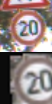

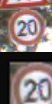

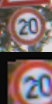

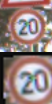

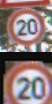

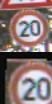

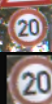

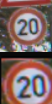

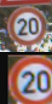

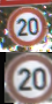

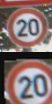

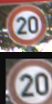

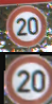

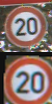

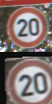

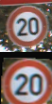

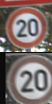

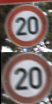

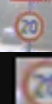

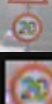

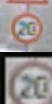

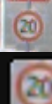

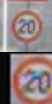

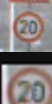

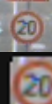

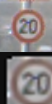

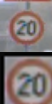

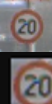

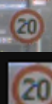

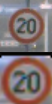

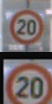

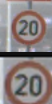

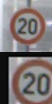

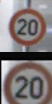

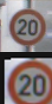

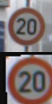

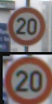

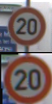

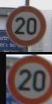

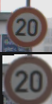

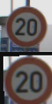

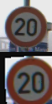

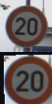

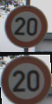

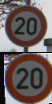

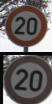

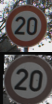

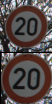

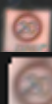

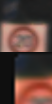

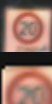

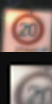

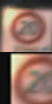

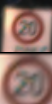

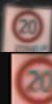

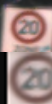

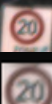

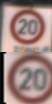

In [156]:
for idx = 1,100 do
    img_before, img_after = getTrainSample(train, idx)
    img = torch.cat(image.scale(img_before, 52, 52), img_after, 2)
    itorch.image(img)
end

  0
 53
 54
  6
  5
 48
 49
[torch.IntTensor of size 7]



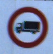

49	


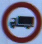

  1
 42
 45
  5
  5
 36
 40
[torch.IntTensor of size 7]



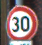

40	


  2
 48
 52
  6
  6
 43
 47
[torch.IntTensor of size 7]



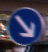

47	


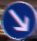

  3
 27
 29
  5
  5
 22
 24
[torch.IntTensor of size 7]



24	


  4
 60
 57
  5
  5
 55
 52
[torch.IntTensor of size 7]



52	


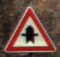

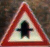

  5
 52
 56
  5
  5
 47
 51
[torch.IntTensor of size 7]



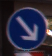

51	


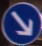

   6
 147
 130
  12
  12
 135
 119
[torch.IntTensor of size 7]



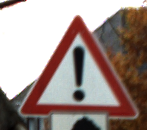

119	


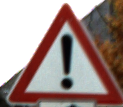

  7
 32
 33
  5
  5
 26
 28
[torch.IntTensor of size 7]



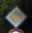

28	


  8
 45
 50
  6
  5
 40
 45
[torch.IntTensor of size 7]



45	


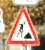

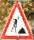

  9
 81
 86
  7
  7
 74
 79
[torch.IntTensor of size 7]



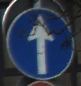

79	


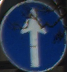

 10
 38
 37
  6
  5
 33
 32
[torch.IntTensor of size 7]



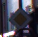

32	


 11
 45
 44
  6
  5
 40
 39
[torch.IntTensor of size 7]



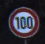

39	


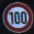

 12
 79
 73
  7
  7
 72
 67
[torch.IntTensor of size 7]



67	


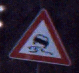

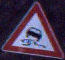

 13
 36
 37
  5
  6
 31
 32
[torch.IntTensor of size 7]



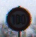

32	


 14
 43
 41
  5
  5
 37
 36
[torch.IntTensor of size 7]



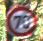

36	


 15
 27
 27
  6
  6
 22
 22
[torch.IntTensor of size 7]



22	


 16
 37
 38
  5
  6
 31
 32
[torch.IntTensor of size 7]



32	


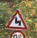

 17
 32
 33
  5
  5
 27
 28
[torch.IntTensor of size 7]



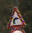

28	


 18
 35
 35
  5
  6
 30
 29
[torch.IntTensor of size 7]



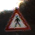

29	


 19
 34
 40
  6
  6
 29
 35
[torch.IntTensor of size 7]



35	


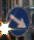

 20
 32
 33
  5
  6
 27
 28
[torch.IntTensor of size 7]



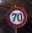

28	


 21
 52
 55
  5
  6
 47
 49
[torch.IntTensor of size 7]



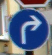

49	


  22
 116
 120
  10
  11
 106
 110
[torch.IntTensor of size 7]



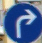

110	


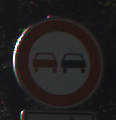

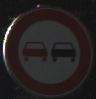

 23
 32
 33
  5
  5
 27
 28
[torch.IntTensor of size 7]



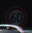

28	


 24
 59
 65
  5
  6
 54
 60
[torch.IntTensor of size 7]



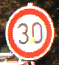

60	


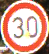

 25
 35
 34
  6
  5
 30
 29
[torch.IntTensor of size 7]



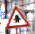

29	


 26
 56
 49
  5
  6
 51
 43
[torch.IntTensor of size 7]



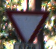

43	


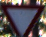

 27
 28
 29
  5
  6
 23
 24
[torch.IntTensor of size 7]



24	


 28
 34
 36
  6
  6
 29
 30
[torch.IntTensor of size 7]



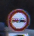

30	


 29
 38
 35
  6
  5
 33
 30
[torch.IntTensor of size 7]



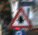

30	


 30
 40
 40
  5
  5
 35
 35
[torch.IntTensor of size 7]



35	


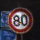

 31
 29
 34
  5
  6
 24
 29
[torch.IntTensor of size 7]



29	


 32
 53
 54
  5
  6
 48
 49
[torch.IntTensor of size 7]



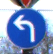

49	


 33
 50
 47
  5
  5
 45
 42
[torch.IntTensor of size 7]



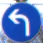

42	


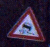

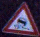

 34
 58
 59
  6
  6
 53
 54
[torch.IntTensor of size 7]



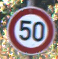

54	


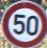

 35
 33
 34
  6
  6
 28
 29
[torch.IntTensor of size 7]



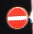

29	


 36
 34
 36
  5
  6
 29
 31
[torch.IntTensor of size 7]



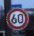

31	


 37
 80
 74
  8
  6
 73
 68
[torch.IntTensor of size 7]



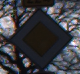

68	


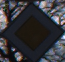

 38
 30
 31
  5
  6
 25
 26
[torch.IntTensor of size 7]



26	


 39
 43
 43
  6
  6
 38
 38
[torch.IntTensor of size 7]



38	


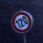

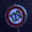

 40
 71
 70
  7
  6
 65
 64
[torch.IntTensor of size 7]



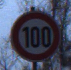

64	


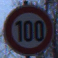

 41
 37
 35
  5
  5
 31
 29
[torch.IntTensor of size 7]



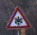

29	


  42
 105
  91
  10
   8
  96
  83
[torch.IntTensor of size 7]



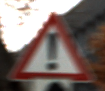

83	


 43
 41
 40
  6
  5
 36
 35
[torch.IntTensor of size 7]



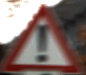

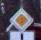

35	


 44
 75
 66
  7
  6
 68
 60
[torch.IntTensor of size 7]



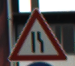

60	


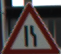

 45
 46
 49
  6
  5
 41
 44
[torch.IntTensor of size 7]



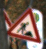

44	


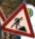

 46
 33
 33
  5
  5
 28
 28
[torch.IntTensor of size 7]



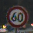

28	


 47
 31
 31
  5
  5
 26
 26
[torch.IntTensor of size 7]



26	


 48
 34
 34
  6
  6
 29
 29
[torch.IntTensor of size 7]



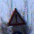

29	


 49
 41
 40
  5
  5
 35
 35
[torch.IntTensor of size 7]



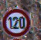

35	


 50
 27
 27
  5
  5
 22
 22
[torch.IntTensor of size 7]



22	


  51
 155
 143
  13
  12
 142
 131
[torch.IntTensor of size 7]



131	


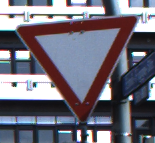

 52
 97
 87
  9
  8
 89
 80
[torch.IntTensor of size 7]



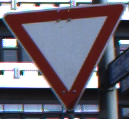

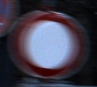

80	


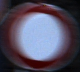

 53
 46
 47
  6
  6
 41
 42
[torch.IntTensor of size 7]



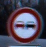

42	


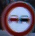

 54
 95
 87
  9
  7
 87
 80
[torch.IntTensor of size 7]



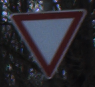

80	


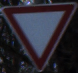

 55
 34
 34
  5
  6
 29
 29
[torch.IntTensor of size 7]



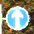

29	


 56
 37
 34
  6
  5
 32
 29
[torch.IntTensor of size 7]



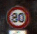

29	


 57
 58
 54
  5
  6
 53
 49
[torch.IntTensor of size 7]



49	


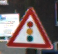

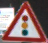

 58
 33
 35
  5
  5
 28
 30
[torch.IntTensor of size 7]



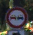

30	


 59
 36
 37
  6
  5
 31
 32
[torch.IntTensor of size 7]



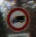

32	


 60
 93
 93
  9
  9
 85
 85
[torch.IntTensor of size 7]



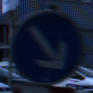

85	


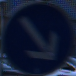

 61
 40
 40
  6
  6
 35
 35
[torch.IntTensor of size 7]



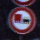

35	


 62
 53
 54
  5
  6
 48
 49
[torch.IntTensor of size 7]



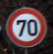

49	


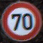

 63
 36
 37
  5
  6
 31
 32
[torch.IntTensor of size 7]



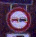

32	


 64
 42
 42
  5
  6
 37
 37
[torch.IntTensor of size 7]



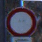

37	


 65
 52
 51
  6
  5
 47
 46
[torch.IntTensor of size 7]



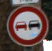

46	


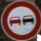

 66
 28
 27
  6
  6
 22
 22
[torch.IntTensor of size 7]



22	


 67
 37
 37
  5
  6
 31
 32
[torch.IntTensor of size 7]



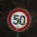

32	


 68
 40
 40
  6
  6
 35
 35
[torch.IntTensor of size 7]



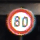

35	


 69
 54
 50
  6
  5
 49
 44
[torch.IntTensor of size 7]



44	


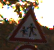

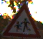

 70
 74
 71
  6
  6
 68
 65
[torch.IntTensor of size 7]



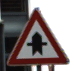

65	


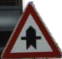

 71
 67
 71
  6
  7
 61
 65
[torch.IntTensor of size 7]



65	


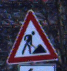

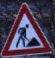

 72
 31
 30
  6
  5
 26
 25
[torch.IntTensor of size 7]



25	


 73
 27
 27
  6
  5
 22
 22
[torch.IntTensor of size 7]



22	


 74
 48
 48
  6
  6
 43
 43
[torch.IntTensor of size 7]



43	


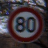

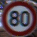

 75
 87
 83
  8
  7
 80
 76
[torch.IntTensor of size 7]



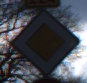

76	


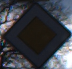

 76
 45
 51
  6
  6
 40
 46
[torch.IntTensor of size 7]



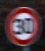

46	


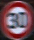

 77
 33
 35
  6
  6
 28
 30
[torch.IntTensor of size 7]



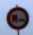

30	


 78
 45
 45
  6
  5
 40
 40
[torch.IntTensor of size 7]



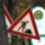

40	


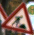

 79
 41
 40
  6
  5
 36
 35
[torch.IntTensor of size 7]



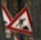

35	


 80
 47
 42
  6
  6
 41
 36
[torch.IntTensor of size 7]



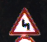

36	


 81
 48
 62
  6
  6
 43
 57
[torch.IntTensor of size 7]



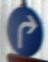

57	


 82
 68
 70
  7
  6
 62
 64
[torch.IntTensor of size 7]



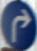

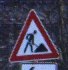

64	


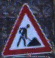

 83
 35
 35
  5
  5
 30
 30
[torch.IntTensor of size 7]



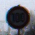

30	


 84
 58
 57
  6
  5
 53
 52
[torch.IntTensor of size 7]



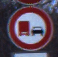

52	


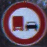

 85
 53
 53
  6
  6
 48
 48
[torch.IntTensor of size 7]



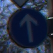

48	


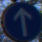

  86
  98
 105
   8
   9
  90
  96
[torch.IntTensor of size 7]



96	


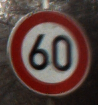

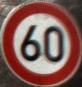

 87
 36
 41
  5
  6
 31
 35
[torch.IntTensor of size 7]



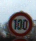

35	


 88
 84
 80
  8
  8
 77
 73
[torch.IntTensor of size 7]



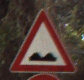

73	


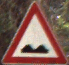

 89
 32
 37
  5
  6
 27
 32
[torch.IntTensor of size 7]



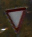

32	


 90
 36
 36
  6
  5
 31
 31
[torch.IntTensor of size 7]



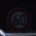

31	


 91
 43
 43
  5
  5
 38
 38
[torch.IntTensor of size 7]



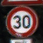

38	


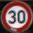

 92
 42
 40
  5
  5
 36
 35
[torch.IntTensor of size 7]



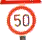

35	


  93
 100
  97
   8
   8
  92
  88
[torch.IntTensor of size 7]



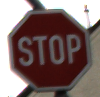

88	


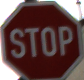

 94
 71
 70
  7
  6
 65
 64
[torch.IntTensor of size 7]



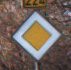

64	


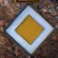

 95
 29
 29
  5
  5
 24
 24
[torch.IntTensor of size 7]



24	


 96
 42
 43
  6
  6
 37
 38
[torch.IntTensor of size 7]



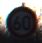

38	


 97
 31
 30
  5
  5
 25
 24
[torch.IntTensor of size 7]



24	


 98
 41
 41
  6
  6
 36
 36
[torch.IntTensor of size 7]



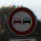

36	


 99
 39
 49
  5
  6
 34
 44
[torch.IntTensor of size 7]



44	


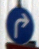

In [167]:
for idx = 1,100 do
    img_after = getTestSample(test, idx)
    itorch.image(img_after)
end